In [1]:
from sys import executable
!{executable} -m pip install tqdm pandas matplotlib

In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


### Preprocess files with https://github.com/amir-zeldes/rst2dep

In [3]:
# Processing rs3 files with Zeldes's parser
base_dir = "./"
rs3_dir = base_dir + "data/blogs/rs3/"

rs3_files = [rs3_dir + file for file in listdir(rs3_dir) if file.endswith('.rs3')]

for file_name in tqdm(rs3_files):
    !./rst2dep/rst2dep.py {file_name}

Traceback (most recent call last):
  File "./rst2dep/rst2dep.py", line 425, in <module>
    nodes = read_rst(rstfile,{})
  File "./rst2dep/rst2dep.py", line 244, in read_rst
    contents = segment.childNodes[0].data.strip()
IndexError: list index out of range
Traceback (most recent call last):
  File "./rst2dep/rst2dep.py", line 441, in <module>
    edus = list(nodes[nid] for nid in nodes if nodes[nid].kind=="edu")
  File "./rst2dep/rst2dep.py", line 441, in <genexpr>
    edus = list(nodes[nid] for nid in nodes if nodes[nid].kind=="edu")
TypeError: string indices must be integers, not str
Traceback (most recent call last):
  File "./rst2dep/rst2dep.py", line 441, in <module>
    edus = list(nodes[nid] for nid in nodes if nodes[nid].kind=="edu")
  File "./rst2dep/rst2dep.py", line 441, in <genexpr>
    edus = list(nodes[nid] for nid in nodes if nodes[nid].kind=="edu")
TypeError: string indices must be integers, not str
Traceback (most recent call last):
  File "./rst2dep/rst2dep.py", li

In [4]:
# Counting lost files 
rsd_dir = base_dir + "data/blogs/rsd/"
rsd_files = [file for file in listdir(rsd_dir) if file.endswith('.rsd')]

f"We have a {100 - len(rsd_files) / len(rs3_files) * 100 :.2f}% data loss with this parser"

'We have a 9.71% data loss with this parser'

### Parse preprocessed files and process them to csv

In [5]:
import re

URL_REGEXP = r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*'

def process_string(string, file_name):
    '''
    Function for deleting EDUs containing IMG,
    changes URLs to "здесь",
    changes "minus" to "longdash"
    '''
    string = string.replace('IMG', '')
    string = re.sub(URL_REGEXP, 'здесь', string)
    string = re.sub(r'[0-9]+$', '', string)

    if string.startswith("-"):
        string = u"—" + string[1:]

    return string.strip()

In [6]:
import csv
from io import StringIO

processed_dir = base_dir + 'data/blogs/processed/'

for file_name in tqdm(rsd_files): 
    # headers
    result = ['EDU_1;EDU_2;Relation'] 

    # opens rsd-file
    with open(rsd_dir + file_name) as file: 
        csv_str = file.read() + '\n' 
        # We need to delete the ' and " characters from the csv
        escaped_csv_str = csv_str.replace("\"", '').replace("\'", '').replace(";", '')

    # reading csv to df  
    df = pd.read_csv(StringIO(escaped_csv_str),
                     sep="\t",
                     encoding='utf-8',
                     names=["self_id", "snippet", "q", "w", "e", "feats", "dep_parent", "dep_rel", "r", "t"])
    
    # deleting ROOTs (the highest groups of EDUs in the hierarchy) and EDUs which are IMG files
    for index, row in df.iterrows():
        if row['dep_rel'].strip() == 'ROOT' or row['snippet'].strip() == "IMG":
            continue
            
        # searching parent for EDU1
        parent_snippet_vals = df[df['self_id'] == row['dep_parent']].values

        if len(parent_snippet_vals) != 0:
            snippet_text = process_string(row['snippet'], file_name)
            parent_text = process_string(parent_snippet_vals[0][1], file_name)

            result.append(';'.join([snippet_text,
                                   parent_text,
                                   row['dep_rel']]))
            
        # writing result into csv
        with open(processed_dir + file_name[:-4] + '.csv', 'w', encoding='utf-8') as fout:
            fout.write('\n'.join(result))

### Merging CSV files into DataFrame

In [7]:
import glob

In [8]:
all_files = glob.glob(processed_dir + "/*.csv")
df_list = [pd.read_csv(filename, index_col=None, header=0, sep=';') for filename in all_files]

df = pd.concat(df_list, axis=0, ignore_index=True)
df.dropna()

,EDU_1,EDU_2,Relation
0,"После поездки в 2017 на Бали я вспомнил, что о...","поэтому в 2018 полетели снова в теплые края, н...",cause_r
1,"поэтому в 2018 полетели снова в теплые края, н...","есть, что посмотреть.",preparation_r
2,(только сейчас руки дошли написать!).,"поэтому в 2018 полетели снова в теплые края, н...",evaluation_r
3,"В общем, прекрасное место!","поэтому в 2018 полетели снова в теплые края, н...",evaluation_r
4,"Остров не маленький,","есть, что посмотреть.",cause_r
...,...,...,...
11752,и примерно такой же будет всегда.,она такая сейчас,sequence_m
11753,Надеяться уже в принципе не на что.,"Это неотъемлемые свойства платформы,",joint_m
11754,"И не то чтобы у меня было для вас что-то получше,",Надеяться уже в принципе не на что.,elaboration_r
11755,"или что я могу сказать, где будущее.","И не то чтобы у меня было для вас что-то получше,",joint_m


### Analytics

In [9]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 12

pd.options.display.float_format = '{:,.3f}'.format

In [10]:
df.describe()

,EDU_1,EDU_2,Relation
count,11745,11748,11757
unique,11652,6384,18
top,[код],"Встать ровно,",joint_m
freq,9,23,2505


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   EDU_1     11745 non-null  object
 1   EDU_2     11748 non-null  object
 2   Relation  11757 non-null  object
dtypes: object(3)
memory usage: 275.7+ KB


In [12]:
list(df['Relation'].unique())

['cause_r',
 'preparation_r',
 'evaluation_r',
 'contrast_m',
 'elaboration_r',
 'joint_m',
 'background_r',
 'purpose_r',
 'sequence_m',
 'comparison_m',
 'solutionhood_r',
 'condition_r',
 'same-unit_m',
 'concession_r',
 'attribution_r',
 'evidence_r',
 'restatement_m',
 'antithesis_r']

In [13]:
len(list(df['Relation'].unique()))

18

In [14]:
df_table = df['Relation'].value_counts().rename_axis('Relation').to_frame('Number of EDUs').astype('int32')

df_table['Percentage'] = (df_table['Number of EDUs'] / sum(df_table['Number of EDUs']) * 100)
df_table['Percentage'] = df_table['Percentage'].round(2).astype(str) + ' %'

df_table

,Number of EDUs,Percentage
Relation,,
joint_m,2505,21.31 %
elaboration_r,2270,19.31 %
contrast_m,1183,10.06 %
cause_r,1016,8.64 %
evaluation_r,896,7.62 %
condition_r,745,6.34 %
sequence_m,647,5.5 %
preparation_r,581,4.94 %
purpose_r,371,3.16 %


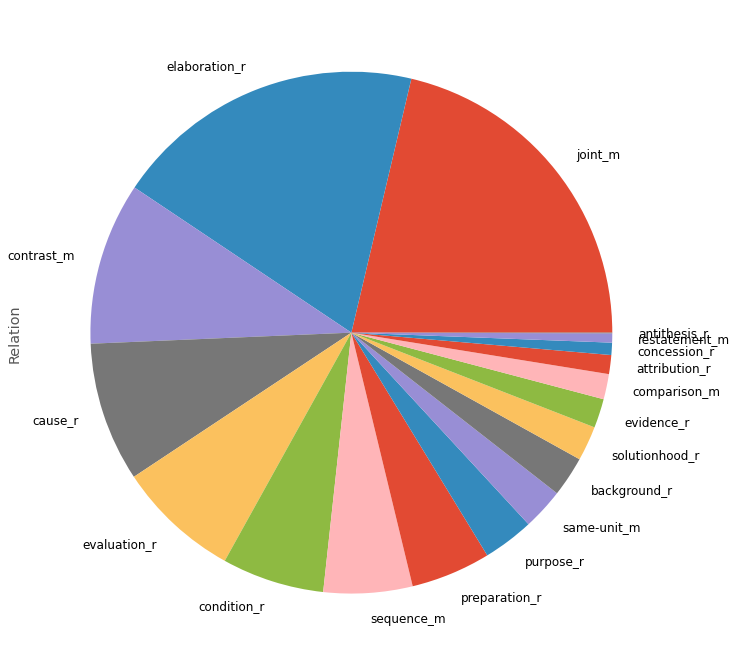

In [15]:
df['Relation'].value_counts().plot(kind='pie')

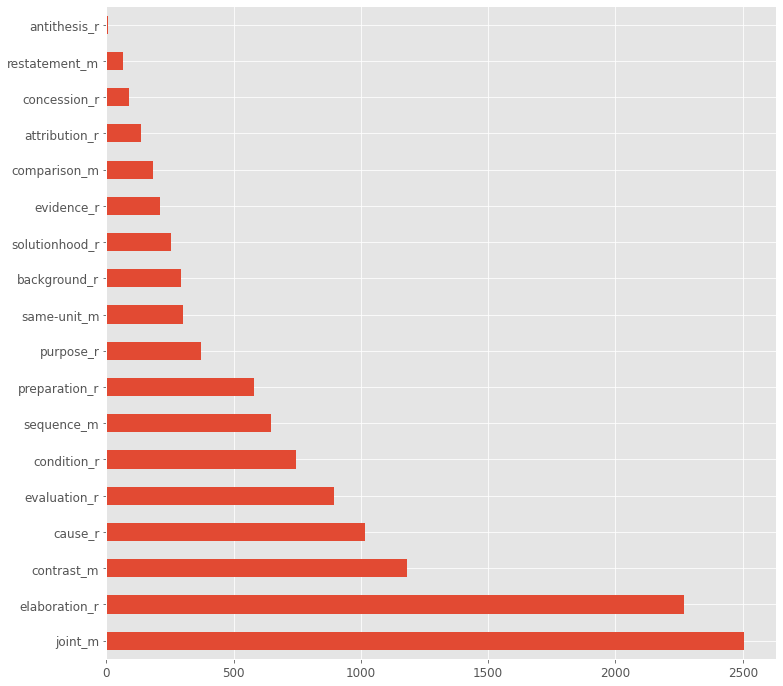

In [16]:
df['Relation'].value_counts().plot(kind='barh')

In [17]:
df['EDU_1_count'] = df['EDU_1'].str.findall(r'(\w+)').str.len()
df['EDU_1_count'] = df['EDU_1_count'].dropna().astype('int32')
df['EDU_1_count']

0       18.000
1       12.000
2        5.000
3        4.000
4        3.000
         ...  
11752    6.000
11753    7.000
11754   12.000
11755    7.000
11756   10.000
Name: EDU_1_count, Length: 11757, dtype: float64

In [18]:
df['EDU_2_count'] = df['EDU_2'].str.findall(r'(\w+)').str.len()
df['EDU_2_count'] = df['EDU_2_count'].dropna().astype('int32')
df['EDU_2_count']

0       12.000
1        3.000
2       12.000
3       12.000
4        3.000
         ...  
11752    3.000
11753    4.000
11754    7.000
11755   12.000
11756   12.000
Name: EDU_2_count, Length: 11757, dtype: float64

In [19]:
EDU_1_count = df['EDU_1_count'].dropna().sum().astype('int32')
EDU_1_count

81653

In [20]:
EDU_1_count_unique = df['EDU_1_count'].dropna().unique().sum().astype('int32')
EDU_1_count_unique

1673

In [21]:
EDU_2_count = df['EDU_2_count'].dropna().sum().astype('int32')
EDU_2_count

85787

In [22]:
EDU_2_count_unique= df['EDU_2_count'].dropna().unique().sum().astype('int32')
EDU_2_count_unique

723

In [23]:
word_count = EDU_1_count + EDU_2_count
f"Total words amount: {word_count}"

'Total words amount: 167440'

In [24]:
word_count_unique = EDU_1_count_unique + EDU_2_count_unique
f"Total unique words amount: {word_count_unique}"

'Total unique words amount: 2396'

In [25]:
df_edus = df['EDU_1'] + df['EDU_2']
df_edus = df_edus.to_frame()
df_edus

,0
0,"После поездки в 2017 на Бали я вспомнил, что о..."
1,"поэтому в 2018 полетели снова в теплые края, н..."
2,(только сейчас руки дошли написать!).поэтому в...
3,"В общем, прекрасное место!поэтому в 2018 полет..."
4,"Остров не маленький,есть, что посмотреть."
...,...
11752,и примерно такой же будет всегда.она такая сейчас
11753,Надеяться уже в принципе не на что.Это неотъем...
11754,И не то чтобы у меня было для вас что-то получ...
11755,"или что я могу сказать, где будущее.И не то чт..."
